In [3]:
import sys
import datetime
from pathlib import Path

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append(str(Path("..").resolve()))
from data_handling import load_state_npz

device = "cpu"
models_dir = Path("models")

print(f"Running on: {device}")
print(f"Looking for models in: {models_dir.resolve()}")

Running on: cpu
Looking for models in: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_polish/tfim_4x4_new/models


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple, Dict, Any


class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))
        self.num_visible = num_visible
        self.num_hidden = num_hidden

    def forward(self, cond: torch.Tensor):
        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)
        return torch.split(
            x,
            [self.num_visible, self.num_visible, self.num_hidden, self.num_hidden],
            dim=-1
        )


class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, gibbs_k: int = 10, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.gibbs_k = gibbs_k
        self.T = T

        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))
        self.conditioner = Conditioner(num_visible, num_hidden, cond_dim, conditioner_width)

    # ------------------------
    # Symmetrized scoring
    # ------------------------
    def _free_energies_pair(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor):
        v = v.to(dtype=self.W.dtype, device=self.W.device)
        v_W = v @ self.W
        W_sum = self.W.sum(dim=0)

        linear_v = v_W + c_mod
        linear_f = W_sum.unsqueeze(0) - v_W + c_mod

        term2_v = F.softplus(linear_v).sum(dim=-1)
        term2_f = F.softplus(linear_f).sum(dim=-1)

        term1_v = -(v * b_mod).sum(dim=-1)
        term1_f = -((1.0 - v) * b_mod).sum(dim=-1)

        F_v = term1_v - term2_v
        F_f = term1_f - term2_f
        return F_v, F_f

    def _free_energy(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor) -> torch.Tensor:
        F_v, F_f = self._free_energies_pair(v, b_mod, c_mod)
        stacked = torch.stack([-F_v, -F_f], dim=-1)
        return -self.T * torch.logsumexp(stacked / self.T, dim=-1)

    def _compute_effective_biases(self, cond: torch.Tensor):
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        if cond.dim() == 1:
            b_mod = (1.0 + gamma_b) * self.b + beta_b
            c_mod = (1.0 + gamma_c) * self.c + beta_c
        else:
            b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
            c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    # ------------------------
    # Fast exact symmetrized Gibbs (no FE inside loop)
    # ------------------------
    @staticmethod
    def _apply_flip(v: torch.Tensor, s0: torch.Tensor) -> torch.Tensor:
        return s0 * v + (1.0 - s0) * (1.0 - v)  # s0=1 keep, s0=0 flip

    def _sample_s_given_v_h(self, v: torch.Tensor, a: torch.Tensor, b_mod: torch.Tensor, rng: torch.Generator):
        vb   = (v * b_mod).sum(dim=-1)
        va   = (v * a).sum(dim=-1)
        bsum = b_mod.sum(dim=-1)
        asum = a.sum(dim=-1)

        dE = (-bsum - asum + 2.0 * vb + 2.0 * va)
        p_s0 = torch.sigmoid(dE / self.T)
        return torch.bernoulli(p_s0, generator=rng).to(v.dtype).unsqueeze(-1)

    def _gibbs_step_sym_fast(
            self,
            v: torch.Tensor,
            h: torch.Tensor,
            s0: torch.Tensor,
            b_mod: torch.Tensor,
            c_mod: torch.Tensor,
            rng: torch.Generator
    ):
        if b_mod.dim() == 1:
            b_mod = b_mod.unsqueeze(0).expand(v.size(0), -1)
        if c_mod.dim() == 1:
            c_mod = c_mod.unsqueeze(0).expand(v.size(0), -1)

        # 1) h | v,s
        v_eff = self._apply_flip(v, s0)
        p_h = torch.sigmoid((v_eff @ self.W + c_mod) / self.T)
        h = torch.bernoulli(p_h, generator=rng)

        # reuse a := W h
        a = h @ self.W.t()

        # 2) s | v,h
        s0 = self._sample_s_given_v_h(v, a, b_mod, rng)

        # 3) v | h,s (sample in effective space, then unflip)
        p_v_eff = torch.sigmoid((a + b_mod) / self.T)
        v_eff = torch.bernoulli(p_v_eff, generator=rng)
        v_next = self._apply_flip(v_eff, s0)

        return v_next, h, s0

    # ------------------------
    # Public API
    # ------------------------
    def log_score(self, v: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        b_mod, c_mod = self._compute_effective_biases(cond)
        return -0.5 * self._free_energy(v, b_mod, c_mod) / self.T

    @torch.no_grad()
    def generate(self, cond: torch.Tensor, n_samples: int, rng: torch.Generator):
        device = self.W.device
        dtype  = self.W.dtype

        cond = cond.to(device=device, dtype=dtype)
        if cond.dim() == 1:
            cond = cond.expand(n_samples, -1)

        b_mod, c_mod = self._compute_effective_biases(cond)

        # start from noise
        v = torch.bernoulli(
            torch.full((n_samples, self.num_visible), 0.5, device=device, dtype=dtype),
            generator=rng
        )

        # chain state
        h = torch.zeros((n_samples, self.num_hidden), device=device, dtype=dtype)
        s0 = torch.bernoulli(
            torch.full((n_samples, 1), 0.5, device=device, dtype=dtype),
            generator=rng
        )

        for _ in range(self.gibbs_k):
            v, h, s0 = self._gibbs_step_sym_fast(v, h, s0, b_mod, c_mod, rng)

        return v

In [5]:
def load_model():

    latest_path = Path("./models/crbm_tfim_4x4_20000_suscept_20251216_010549_gold.pt")
    print(f"Loading checkpoint: {latest_path.name}")

    checkpoint = torch.load(latest_path, map_location=device)
    config = checkpoint["config"]

    model = ConditionalRBM(
        num_visible=config["num_visible"],
        num_hidden=config["num_hidden"],
        cond_dim=1,
        gibbs_k=config.get("gibbs_k", 10),   # NEW
    ).to(device)

    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    return model, config

model, config = load_model()
h_support = config.get("h_support", [])
GEN_SIDE_LENGTH = int(math.sqrt(model.num_visible))

print(f"Model Loaded. System Size: {GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH}")
print(f"Support Points: {h_support}")


Loading checkpoint: crbm_tfim_4x4_20000_suscept_20251216_010549_gold.pt
Model Loaded. System Size: 4x4
Support Points: [1.0, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0]


In [6]:
def estimate_susceptibility_mc(model, h_val, n_samples):
    dtype = next(model.parameters()).dtype
    rng = torch.Generator(device=device).manual_seed(42)

    with torch.no_grad():
        cond_fixed = torch.tensor([[h_val]], device=device, dtype=dtype)
        samples = model.generate(cond_fixed, n_samples, rng)

    # create a batch of conditioning values for later gradient computation
    cond_batch = torch.full((n_samples, 1), h_val, device=device, dtype=dtype, requires_grad=True)

    # we evaluate log_psi with gradients enabled on cond_batch
    log_psi = model.log_score(samples, cond_batch)

    # since we parametrized log_psi with cond_batch the Jacobian has only main diagonal terms
    grads = torch.autograd.grad(
        outputs=log_psi,
        inputs=cond_batch,
        grad_outputs=torch.ones_like(log_psi),      # upstream gradient in VJP (scales each main diag term)
        create_graph=False
    )[0]

    # quadratic formula can be simplified to variance of the gradient (Var(d log_psi / dh))
    chi = torch.var(grads.squeeze(), unbiased=True)
    return chi.item()

In [10]:
h_min = 1.0
h_max = 5.0
num_steps = 50
h_eval = np.linspace(h_min, h_max, num_steps)
gibbs_samples = 10_000

print(f"Estimating Susceptibility (MC) on {num_steps} points...")

chi_values = []

for h in h_eval:
    chi = estimate_susceptibility_mc(model, h, n_samples=gibbs_samples)
    chi_values.append(chi)

    if (len(chi_values) % 10) == 0:
        print(f"h={h:.2f} | chi={chi:.4f}")

print("Sweep Complete.")

Estimating Susceptibility (MC) on 50 points...
h=1.73 | chi=0.3459
h=2.55 | chi=0.7900
h=3.37 | chi=0.1618
h=4.18 | chi=0.0165
h=5.00 | chi=0.0062
Sweep Complete.


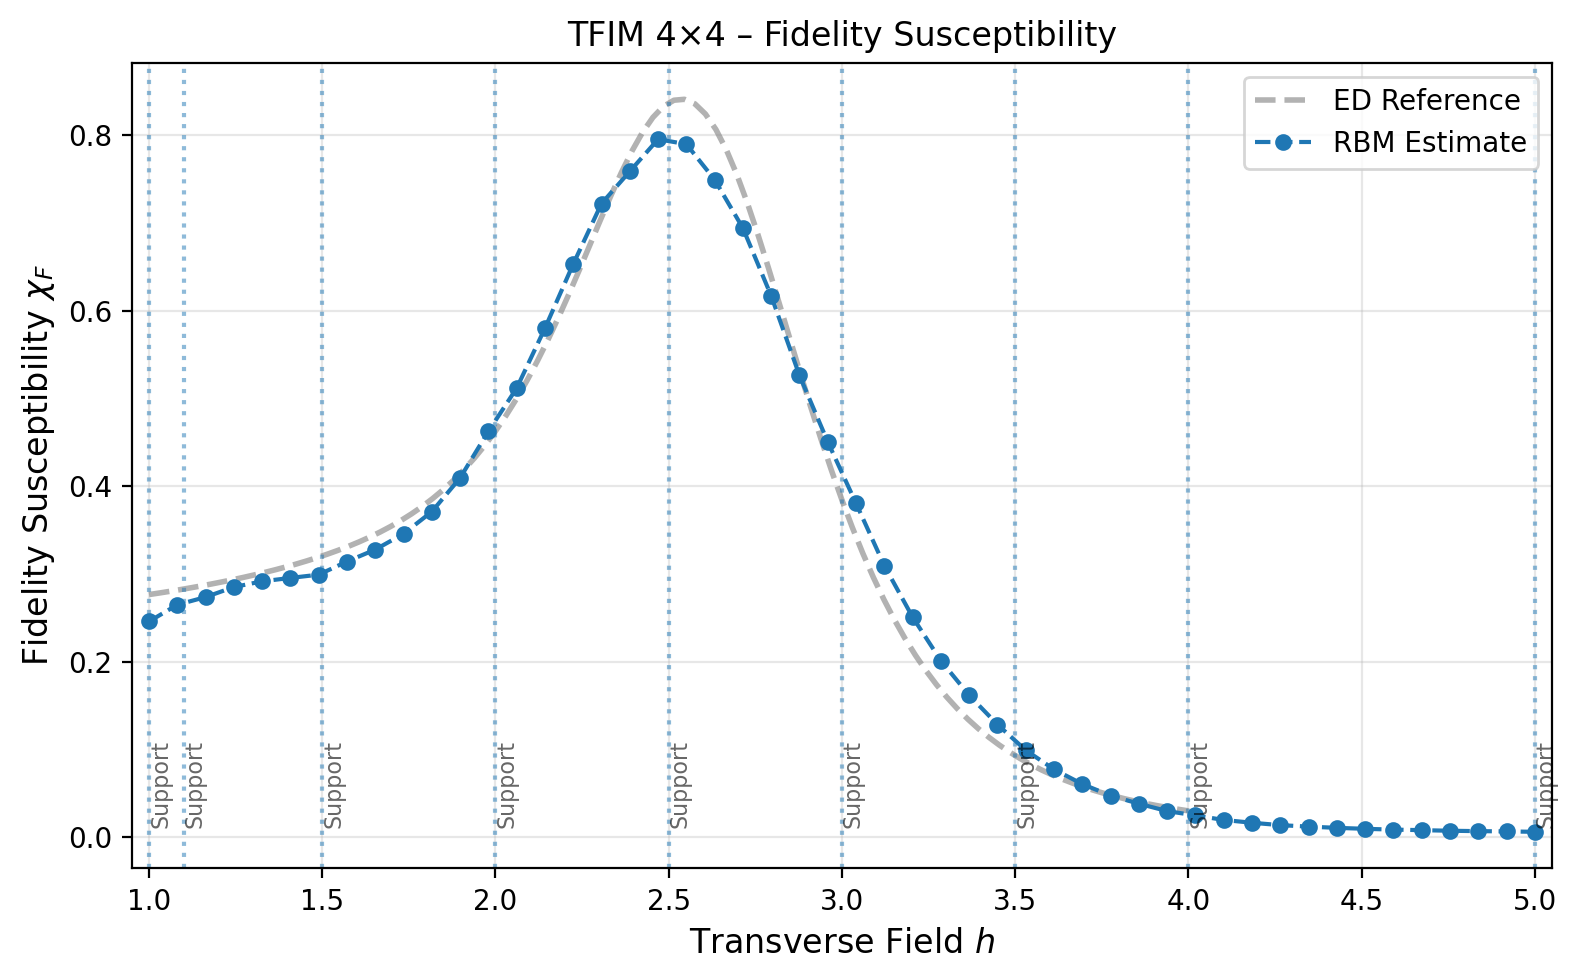

In [12]:
# load reference data if available
ref_file = Path(f"tfim_4x4_suscept_ref.csv")
ref_df = pd.read_csv(ref_file) if ref_file.exists() else None


XLIM = (0.95, 5.05)
SUPPORT_LABEL_YOFFSET = 0.05

plt.figure(figsize=(8,5), dpi=200)

if ref_df is not None:
    plt.plot(ref_df["h"].values, ref_df["chi_F"].values, "--", alpha=0.6, color="gray",
        linewidth=2, label="ED Reference")

plt.plot(h_eval, chi_values, "o--", markersize=5, label="RBM Estimate")

# support markers as lines
ymin, ymax = plt.ylim()
for h_supp in h_support:
    if XLIM[0] <= h_supp <= XLIM[1]:
        plt.axvline(h_supp, linestyle=":", alpha=0.5)
        plt.text(h_supp, ymin + SUPPORT_LABEL_YOFFSET * (ymax - ymin), "Support",
            rotation=90, va="bottom", fontsize=8, alpha=0.6)

plt.xlabel(r"Transverse Field $h$", fontsize=12)
plt.ylabel(r"Fidelity Susceptibility $\chi_F$", fontsize=12)
plt.title(f"TFIM 4×4 – Fidelity Susceptibility", fontsize=12)

plt.xlim(*XLIM)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
data = np.column_stack((h_eval, chi_values))

file_name = f"tfim_4x4_suscept_rbm_mc_{timestamp}.csv"
header = "h,chi_F"

np.savetxt(file_name, data, delimiter=",", header=header, comments="")
print(f"Data saved to: {file_name}")

Data saved to: tfim_4x4_suscept_rbm_mc_20251216_010908.csv
